# Analyse Long Format Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from src.d00_helpers import helpers as h
import seaborn as sns

In [2]:
# read in long dataframe
df = pd.read_excel('G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//01_processed//2024.03.21_Mastertabelle_long.xlsx',
                   parse_dates=['date'], index_col='Unnamed: 0', dtype={'vaccination': "Int64", 'infection':'Int64'})
df.rename(columns={'patient_id':'ID'}, inplace=True)

In [3]:
# read in basline table to get demographic data
bl = pd.read_excel('G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//00_raw//2024.03.21_Mastertabelle.xlsx')
bl_sub=bl[['ID','Alter','Dialyse','Geschlecht']]

In [4]:
# Add information of Dialyse group
df = pd.merge(df, bl[['ID', 'Dialyse']], on='ID', how='left')

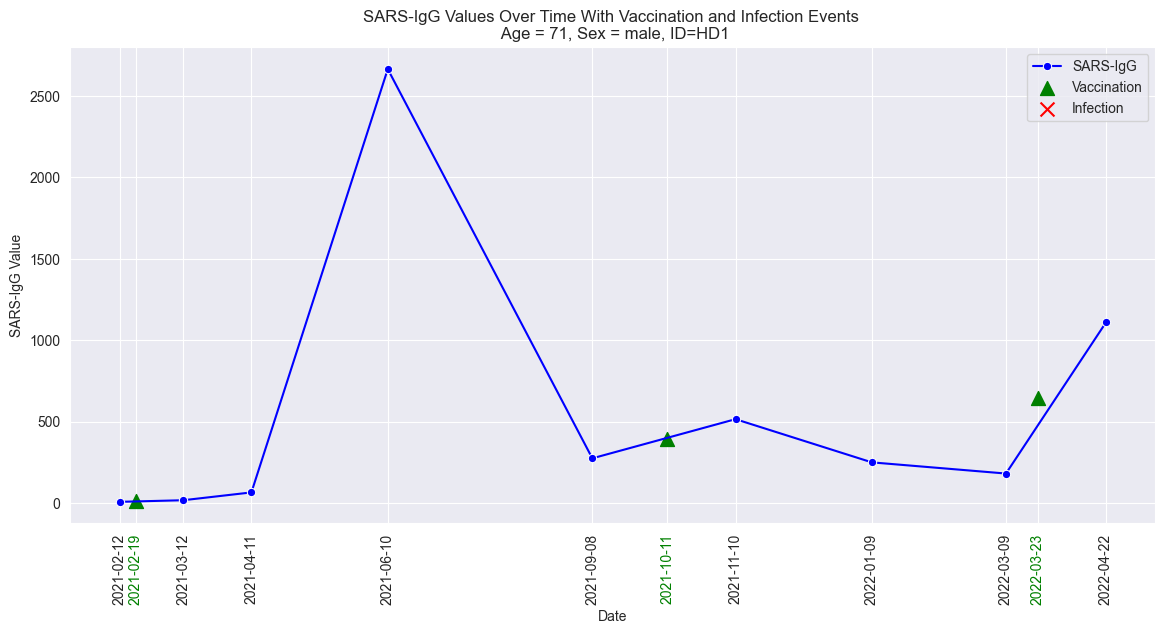

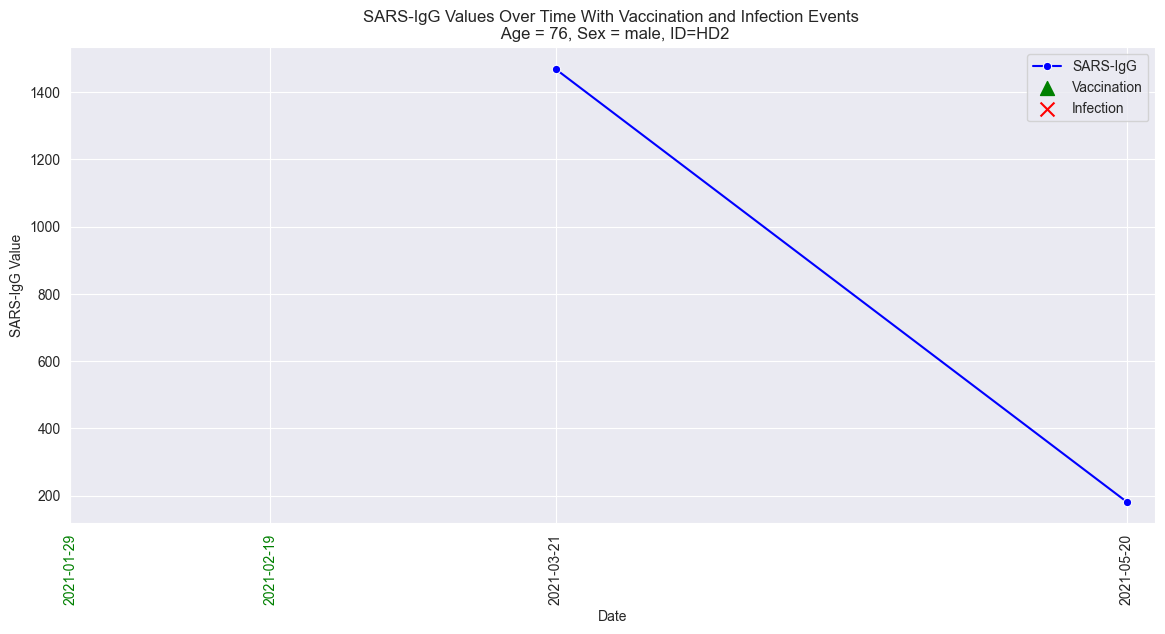

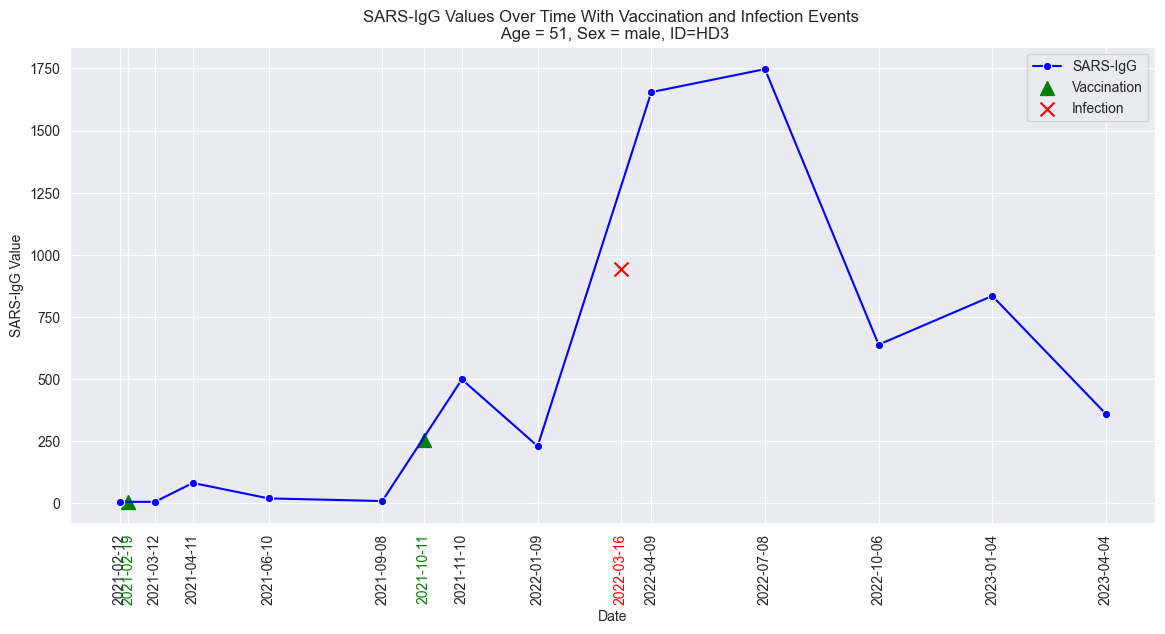

In [5]:
# loop over all patients and create single plots of their specific values
results_path = '../../results/rq1/sars-igg-plots-by-patient'
for id in df.ID.unique()[:3]:
    bl_s = bl_sub[bl_sub['ID'] == id]
    df_s = df[df['ID'] == id]
    h.plot_sars_igg_with_events(df_s, results_path, bl_s, show_plot=True)

In [6]:
# reset index for easier mapping
bl = bl.set_index('ID')

# try to aggregate values and plot these on a time axis
vaccination_groups = dict(df.groupby(['ID'])['vaccination'].sum())
infection_groups = dict(df.groupby(['ID'])['infection'].sum())

In [7]:
# count number of vaccinations and infections
bl['n_vaccinations'] = None
for id in vaccination_groups.keys():
    bl.loc[id, 'n_vaccinations'] = vaccination_groups[id]

bl['n_infections'] = None
for id in infection_groups.keys():
    bl.loc[id, 'n_infections'] = infection_groups[id]

In [8]:
# merge this information into df
sub_df = pd.merge(df, bl[['n_vaccinations','n_infections']], how='left', left_on='ID', right_index=True)
# assign group ids
sub_df['group_id'] = sub_df.groupby(['Dialyse','n_vaccinations']).ngroup()

In [9]:
# sort by date and calculate n_vaccinations and n_infections until current date
sub_df = sub_df.sort_values(by='date')
sub_df['n_vaccinations_so_far'] = sub_df.groupby('ID')['vaccination'].cumsum()
sub_df['n_infections_so_far'] = sub_df.groupby('ID')['infection'].cumsum()

In [10]:
sub_df['event'] = sub_df['infection'] | sub_df['vaccination']

In [11]:
# Ensure the DataFrame is sorted by date
sub_df.sort_values(by='date', inplace=True)

# List to hold the DataFrame of each user after applying the function
dfs = []

# Group by user_id and apply the function to each group
for _, group in sub_df.groupby('ID'):
    group_result = h.calculate_days_since_last_event(group, event_col='event')
    dfs.append(group_result)

# Concatenate all the individual user DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

## What is the correlation of SARS-IgG and days sind last event?

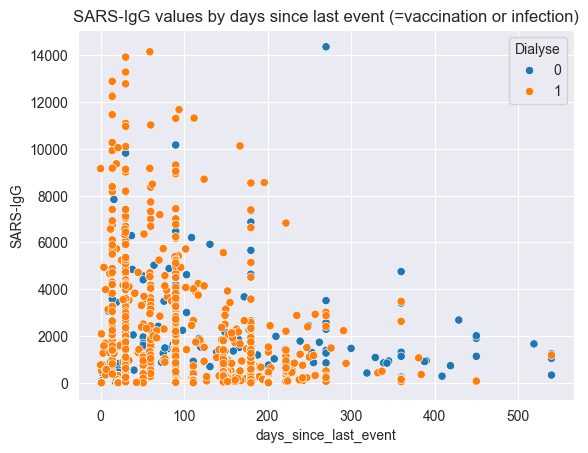

In [12]:
sub_df = result_df[result_df['days_since_last_event'] != -1]
# remove outliers
sub_df = sub_df[sub_df['SARS-IgG']<15000]


sns.scatterplot(sub_df, y='SARS-IgG', x='days_since_last_event', hue='Dialyse')
plt.title('SARS-IgG values by days since last event (=vaccination or infection)')
plt.show()

## What is the average increase in SARS-IgG after an infection?

In [16]:
res_df = pd.DataFrame(columns=['ID', 'slope', 'sars_diff'])
for id in result_df['ID'].unique():

    sub_df = result_df[result_df['ID']==id]

    # timepoint where infection happened
    infection_dates = list(sub_df[sub_df['infection']==1]['date'])

    for infection_date in infection_dates:
        try:
            res = h.calc_average_sarsigg_increase(sub_df, infection_date)

            if res:
                res['ID'] = id
                # Create a DataFrame for the row and use pd.concat to add it to res_df
                row_df = pd.DataFrame([res])  # Encapsulate 'res' in a list to treat it as a row
                res_df = pd.concat([res_df, row_df], ignore_index=True)
        except:
            print(id)


res_df

C58
C59
C60


,ID,slope,sars_diff
0,C10,-0.648667,-97.30
1,C114,18.664021,3620.82
2,C13,22.203778,1998.34
3,C132,9.744222,876.98
4,C137,3.597564,561.22
...,...,...,...
85,HD91,11.779091,518.28
86,HD92,19.776667,3559.80
87,HD94,36.733444,3306.01
88,HD97,139.438571,3904.28
